In [1]:
from collections import deque

# Create the graph

We write the graph of pipes to a dict `conn` where `conn[node] = [adj_node1, adj_node2]` indicates that the pipe at `node` tries to connect to `adj_node1` and `adj_node1`. Two nodes `node1` and `node2` are actually connected if and only if `node1 in conn[node2]` and `node2 in conn[node1]`.

In [2]:
conn = {}
start = None

filepath = "./data/day10.txt"

with open(filepath) as f:
    row = 0
    while line := f.readline():
        line = line.rstrip()
        for col, c in enumerate(line):
            pos = (row, col)
            if c == 'S':
                start = pos
            elif c == '.':
                continue
            elif c == 'F':
                conn[pos] = [(row+1, col), (row, col+1)]
            elif c == '7':
                conn[pos] = [(row+1, col), (row, col-1)]
            elif c == 'J':
                conn[pos] = [(row-1, col), (row, col-1)]
            elif c == 'L':
                conn[pos] = [(row-1, col), (row, col+1)]
            elif c == '-':
                conn[pos] = [(row, col-1), (row, col+1)]
            elif c == '|':
                conn[pos] = [(row+1, col), (row-1, col)]
            else:
                print('we should not be here!', c)
        row += 1

In [3]:
start

(83, 25)

We don't need to figure out what the start node pipe actually is. We can simply set it to "connect" to all 4 possible cells.

In [4]:
conn[start] = [(start[0]+i, start[1]) for i in [-1, 1]] + [(start[0], start[1]+i) for i in [-1, 1]]
conn[start]

[(82, 25), (84, 25), (83, 24), (83, 26)]

# Part 1

BFS from start node. Keep track of the length of the path and print max length.

In [5]:
q = deque()
q.append(start + (0,))
visited = {start}
m = 0
while q:
    row, col, d = q.pop()
    m = d
    for row2, col2 in conn[(row, col)]:
        if (row2, col2) in visited:
            continue
        if (row2, col2) not in conn:
            continue
        if (row, col) not in conn[(row2, col2)]:
            continue
        q.appendleft((row2, col2, d+1))
        visited.add((row2, col2))
m

6754

# Part 2, v1

Plan: We'll double the size of the grid. We will fill only loop nodes and the spaces between two connected loop nodes. Then we'll BFS from every non-loop node to see if we can get to the edge or not. If we can, it is an "outside" node; if not it is enclosed.

First, let's record which nodes are in the loop.

In [6]:
loop = {start}
q = deque()
q.append(start)
while q:
    node = q.pop()
    for adj_node in conn[node]:
        if adj_node in loop:
            continue
        if adj_node not in conn:
            continue
        if node not in conn[adj_node]:
            continue
        q.appendleft(adj_node)
        loop.add(adj_node)

In [7]:
len(loop)

13508

We need the number of rows and columns for bounds checking so let's save them in variables.

In [8]:
max_row, max_col = 140, 140

Now, let's figure out which cells or nodes are filled in the large grid. We first define a helper function to check if two nodes are connected:

In [9]:
def connected(node1, node2):
    if (node1 not in conn) or (node2 not in conn):
        return False
    return (node1 in conn[node2]) and (node2 in conn[node1])

Then we create the big loop, i.e. fill the cells in the large grid:

In [10]:
big_loop = set()
for row, col in loop:
    big_loop.add((2*row, 2*col))
    for i in [-1, 1]:
        if connected((row, col), (row+i, col)):
            big_loop.add((2*row+i, 2*col))
        if connected((row, col), (row, col+i)):
            big_loop.add((2*row, 2*col+i))

The size of the big loop should be exactly twice the length of the original loop:

In [11]:
len(big_loop), 2*len(loop)

(27016, 27016)

Now we are ready to compute the enclosed points. We'll run BFS starting at every non-loop point. If we get to the edge, we will mark all the points in the BFS as outside points. If we did not reach the edge, we mark the points as inside points, i.e. enclosed points.

Note that we loop points from the original grid, but the BFS is done in the doubled grid. So when we mark points as outside/inside after the BFS, we only consider points from the oroginal grid and we need to rescale the points back to the original grid, i.e. (row, col) -> (row//2, col//2).

In [12]:
outside_points = set()
inside_points = set()
for r in range(max_row):
    for c in range(max_col):
        point = (r, c)
        if point in loop:
            continue
        if point in outside_points:
            continue
        if point in inside_points:
            continue
        outside_flag = False
        path = set()
        path.add((2*r, 2*c))
        q = deque()
        q.append((2*r, 2*c))
        while q:
            row, col = q.pop()
            for i in [-1, 1]:
                if row+i < 0 or row+i >= 2*max_row:
                    outside_flag = True
                    continue
                if (row+i, col) in big_loop:
                    continue
                if (row+i, col) in path:
                    continue
                path.add((row+i, col))
                q.appendleft((row+i, col))
            for i in [-1, 1]:
                if col+i < 0 or col+i >= 2*max_col:
                    outside_flag = True
                    continue
                if (row, col+i) in big_loop:
                    continue
                if (row, col+i) in path:
                    continue
                path.add((row, col+i))
                q.appendleft((row, col+i))
        if outside_flag:
            for a, b in path:
                if a%2 == 0 and b%2 == 0:
                    outside_points.add((a//2, b//2))
        else:
            for a, b in path:
                if a%2 == 0 and b%2 == 0:
                    inside_points.add((a//2, b//2))

To make sure the numbers make sense, we print:
- number of points in the entire grid,
- number of points in the loop,
- number of points outside the loop,
- number of points inside the loop,
- total points - loop points - outside points (which needs to be equal to the number of points inside the loop).

In [13]:
max_row*max_col, len(loop), len(outside_points), len(inside_points), max_row*max_col-len(loop)-len(outside_points)

(19600, 13508, 5525, 567, 567)

# Part 2, v2

Idea: Flood fill the big grid from the outer edge. The number of cells with even coordinates not filled will be equal to the number of enclosed cells.

In [14]:
filled = set()

def flood(start_row, start_col):
    if (start_row, start_col) in filled or (start_row, start_col) in big_loop:
        return
    filled.add((start_row, start_col))
    stack = []
    stack.append((start_row, start_col))
    while stack:
        row, col = stack.pop()
        for i in [-1, 1]:
            if row+i < 0 or row+i >= 2*max_row:
                continue
            if (row+i, col) in filled or (row+i, col) in big_loop:
                continue
            filled.add((row+i, col))
            stack.append((row+i, col))
        for i in [-1, 1]:
            if col+i < 0 or col+i >= 2*max_col:
                continue
            if (row, col+i) in filled or (row, col+i) in big_loop:
                continue
            filled.add((row, col+i))
            stack.append((row, col+i))

for i in range(max_row):
    flood(i, 0)
    flood(i, 2*max_col-1)
for i in range(max_col):
    flood(0, i)
    flood(2*max_row-1, i)

In [15]:
m = 0
for row in range(max_row):
    for col in range(max_col):
        m += (2*row, 2*col) not in filled and (row, col) not in loop
m

567

# Runtime

This flood fill solution is much more readable than the initial BFS solution imo. Is it faster though?

In [16]:
%%timeit

outside_points = set()
inside_points = set()
for r in range(max_row):
    for c in range(max_col):
        point = (r, c)
        if point in loop:
            continue
        if point in outside_points:
            continue
        if point in inside_points:
            continue
        outside_flag = False
        path = set()
        path.add((2*r, 2*c))
        q = deque()
        q.append((2*r, 2*c))
        while q:
            row, col = q.pop()
            for i in [-1, 1]:
                if row+i < 0 or row+i >= 2*max_row:
                    outside_flag = True
                    continue
                if (row+i, col) in big_loop:
                    continue
                if (row+i, col) in path:
                    continue
                path.add((row+i, col))
                q.appendleft((row+i, col))
            for i in [-1, 1]:
                if col+i < 0 or col+i >= 2*max_col:
                    outside_flag = True
                    continue
                if (row, col+i) in big_loop:
                    continue
                if (row, col+i) in path:
                    continue
                path.add((row, col+i))
                q.appendleft((row, col+i))
        if outside_flag:
            for a, b in path:
                if a%2 == 0 and b%2 == 0:
                    outside_points.add((a//2, b//2))
        else:
            for a, b in path:
                if a%2 == 0 and b%2 == 0:
                    inside_points.add((a//2, b//2))

79.7 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit

filled = set()

def flood(start_row, start_col):
    if (start_row, start_col) in filled or (start_row, start_col) in big_loop:
        return
    filled.add((start_row, start_col))
    stack = []
    stack.append((start_row, start_col))
    while stack:
        row, col = stack.pop()
        for i in [-1, 1]:
            if row+i < 0 or row+i >= 2*max_row:
                continue
            if (row+i, col) in filled or (row+i, col) in big_loop:
                continue
            filled.add((row+i, col))
            stack.append((row+i, col))
        for i in [-1, 1]:
            if col+i < 0 or col+i >= 2*max_col:
                continue
            if (row, col+i) in filled or (row, col+i) in big_loop:
                continue
            filled.add((row, col+i))
            stack.append((row, col+i))

for i in range(max_row):
    flood(i, 0)
    flood(i, 2*max_col-1)
for i in range(max_col):
    flood(0, i)
    flood(2*max_row-1, i)

m = 0
for row in range(max_row):
    for col in range(max_col):
        m += (2*row, 2*col) not in filled and (row, col) not in loop

47.2 ms ± 772 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Neither is slow, but the flood fill is still quite a bit faster.

With my input the loop actually does not even touch the edge of the grid so we don't even need to start the fill from every node on the edge. I still added it to make the solution work with any input. Let's see if this makes a difference in the runtime.

In [18]:
%%timeit

filled = set()

def flood(start_row, start_col):
    if (start_row, start_col) in filled or (start_row, start_col) in big_loop:
        return
    filled.add((start_row, start_col))
    stack = []
    stack.append((start_row, start_col))
    while stack:
        row, col = stack.pop()
        for i in [-1, 1]:
            if row+i < 0 or row+i >= 2*max_row:
                continue
            if (row+i, col) in filled or (row+i, col) in big_loop:
                continue
            filled.add((row+i, col))
            stack.append((row+i, col))
        for i in [-1, 1]:
            if col+i < 0 or col+i >= 2*max_col:
                continue
            if (row, col+i) in filled or (row, col+i) in big_loop:
                continue
            filled.add((row, col+i))
            stack.append((row, col+i))

flood(0, 0)

m = 0
for row in range(max_row):
    for col in range(max_col):
        m += (2*row, 2*col) not in filled and (row, col) not in loop

47.6 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


No difference. I suppose a couple thousand set membership checks are practically instant.

# Visualizing the fill

Just for the fun of it. Let's create a quick gif of the second solution to part 2.

In [19]:
from PIL import Image
import numpy as np
from IPython.display import Image as IPyImage

In [20]:
filled = set()

def viz_flood(start_row, start_col):
    steps = 0
    images = []
    arr = np.zeros((280, 280))
    for row in range(280):
        for col in range(280):
            if (row, col) in big_loop:
                arr[row, col] = 255
            elif (row, col) in filled:
                arr[row, col] = 127
    im = Image.fromarray(arr)
    im = im.resize((280*3, 280*3))
    images.append(im)

    if (start_row, start_col) in filled or (start_row, start_col) in big_loop:
        return
    filled.add((start_row, start_col))
    stack = []
    stack.append((start_row, start_col))
    while stack:
        steps += 1
        if steps%100 == 0:
            arr = np.zeros((280, 280))
            for row in range(280):
                for col in range(280):
                    if (row, col) in big_loop:
                        arr[row, col] = 255
                    elif (row, col) in filled:
                        arr[row, col] = 127
            im = Image.fromarray(arr)
            im = im.resize((280*3, 280*3))
            images.append(im)
        
        row, col = stack.pop()
        for i in [-1, 1]:
            if row+i < 0 or row+i >= 2*max_row:
                continue
            if (row+i, col) in filled or (row+i, col) in big_loop:
                continue
            filled.add((row+i, col))
            stack.append((row+i, col))
        for i in [-1, 1]:
            if col+i < 0 or col+i >= 2*max_col:
                continue
            if (row, col+i) in filled or (row, col+i) in big_loop:
                continue
            filled.add((row, col+i))
            stack.append((row, col+i))
    
    arr = np.zeros((280, 280))
    for row in range(280):
        for col in range(280):
            if (row, col) in big_loop:
                arr[row, col] = 255
            elif (row, col) in filled:
                arr[row, col] = 127
    im = Image.fromarray(arr)
    im = im.resize((280*3, 280*3))
    images.append(im)

    return images

images = viz_flood(0, 0)

In [21]:
arr = np.zeros((140, 140))
for row in range(280):
    for col in range(280):
        if (row, col) in loop:
            arr[row, col] = 255
first_im = Image.fromarray(arr)
first_im = first_im.resize((140*2*3, 140*2*3))

arr = np.zeros((140, 140))
for row in range(280):
    for col in range(280):
        if (row, col) in loop:
            arr[row, col] = 255
        elif (2*row, 2*col) in filled:
            arr[row, col] = 127
last_im = Image.fromarray(arr)
last_im = last_im.resize((140*2*3, 140*2*3))

first_im.save('viz/day10.gif', save_all=True, append_images=images + [last_im,], optimize=False, duration=[2000, 2000] + [50]*(len(images)-2) + [2000, 2000], loop=0)

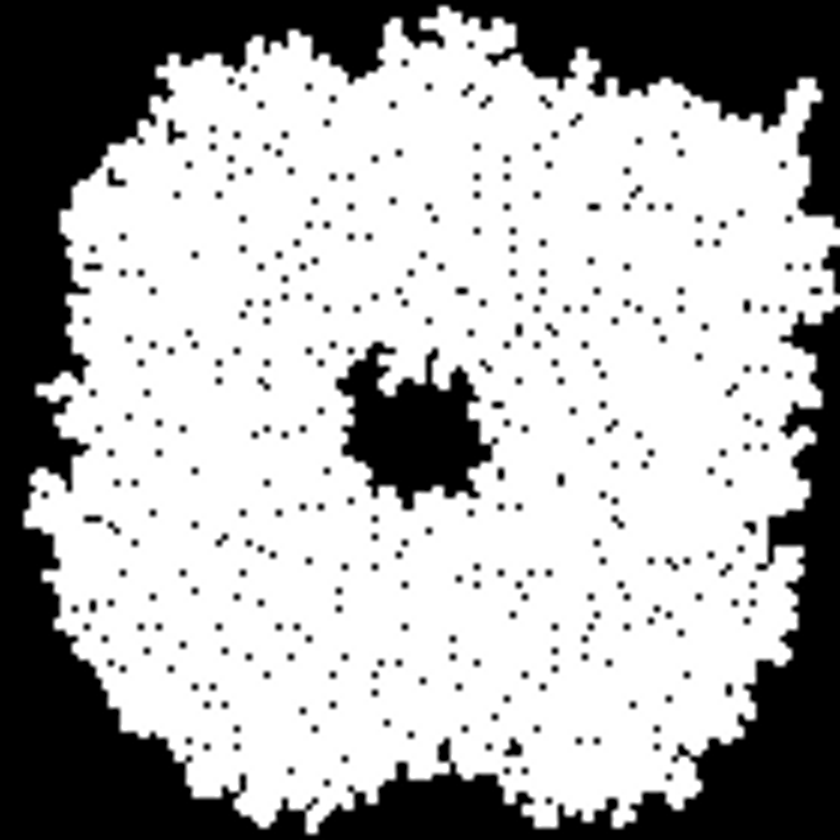

In [22]:
IPyImage('viz/day10.gif')

In the above gif, the first frame shows the loop in white pixels. Then, we do the doubling of the grid after which we start DFS filling in gray from the top left corner. After we've filled everything, we shrink back to the original grid. In the final image, the black pixels are the enclosed points.